# semi-automated ROI detection for cervical connective data <br>
Jonas Braun<br>
jonas.braun@epfl.ch<br>
18.05.2021


In [89]:
import os, sys
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import pickle

from skimage.feature import peak_local_max
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt

import utils2p

# define directories and load summary images of data<br>
## adapt this to the location of your data

In [118]:
base_dir = "/mnt/NAS2/LH/210618/fly5/processed"
# "/mnt/NAS2/LH/210618/fly5/processed" # - 82 ROIS
# "/mnt/NAS2/LH/210603/fly2/processed" # - 97 ROIS
# "/mnt/NAS2/LH/210602/fly2/processed" - 
# "/mnt/NAS2/LH/210526/fly2/processed" #67 ROIS
# "/mnt/NAS2/LH/210527/fly4/processed" # 78 ROIS
# "/mnt/NAS2/LH/210521/fly1/processed"  #- 68 ROIs
# "/mnt/NAS2/LH/210512/fly3/processed"  #- around 80 ROIs?
# "/mnt/NAS2/LH/210519/fly1/processed" # - 75 ROIs
pkl_dir = join(base_dir, "compare_trials.pkl")
with open(pkl_dir, "rb") as f:
    summary_dict = pickle.load(f)
mask_dir = join(base_dir, "dff_mask_denoised_t1.tif")
mask = utils2p.load_img(mask_dir) == 0
out_file = join(base_dir, "ROI_centers.txt")

In [91]:
summary_dict.keys()

dict_keys(['dff_means', 'dff_mean_diffs', 'green_means', 'green_mean_diffs', 'dff_stds', 'dff_std_diffs', 'green_stds', 'green_std_diffs', 'dff_quants', 'dff_quant_diffs', 'green_quants', 'green_quant_diffs', 'dff_local_corrs', 'dff_local_corr_diffs', 'green_local_corrs', 'green_local_corr_diffs', 'trials'])

# prepare images & compute maxima for summary images

In [92]:
local_corrs = summary_dict["green_local_corrs"]
local_corr_all = np.mean(local_corrs, axis=0)
local_corr_all[mask] = 0
stds = summary_dict["green_stds"]
std_all = np.mean(stds, axis=0)
std_all[mask] = 0
maxs = summary_dict["green_quants"]
max_all = np.max(maxs, axis=0)
max_all[mask] = 0

In [93]:
local_peak_std = peak_local_max(std_all, min_distance=5, threshold_abs=0.001)
local_peak_max = peak_local_max(max_all, min_distance=5, threshold_abs=0.001)
local_peak_corr = peak_local_max(local_corr_all, min_distance=5, threshold_abs=0.001)

## this is how we'll collect the results: <br>
1. we performed local peak detection for the std image and the max image in the cell above.
2. we'll look at them and confirm whether they actually correspond to neurons
3. if so, then we'll write their number into the corresponding list.
4. additionally, we can add ROIs that the local maximum computation did not catch
5. finally, we can also look at the local correlation image to confirm out results
### the same cell will be below the plot again, so we don't have to scroll so much
#### be sure to save the notebook regularly to not loose your progress

In [94]:
# numbers of peaks in standard deviation image as shown on the left of the plot below
std_confirmed_rois = []
# numbers of peaks in standard deviation image as shown on the right of the plot below
max_confirmed_rois = []
# numbers of peaks in local correlation image as shown on the bottom of the notebook
corr_confirmed_rois = []
# y and x coordinates of additional rois as [y, x], i.e. a list of lists: [[y1, x1], [y2, x2]]
additional_rois = [[0,0]]

confirmed_rois = np.vstack((local_peak_std[std_confirmed_rois, :], 
                            local_peak_max[max_confirmed_rois, :], 
                            local_peak_corr[corr_confirmed_rois, :], 
                            additional_rois))
print("Number of confirmed ROIs: {}".format(len(confirmed_rois)))

Number of confirmed ROIs: 1


# now we're plotting the results <br>
- on the left side, we see the standard deviation of all trials (top) and within trials (bottomt)
- on the right side, we see the maximum of all trials (top) and within trials (bottom)
- red stars indicate peaks that are at least 5 pixels apart (weaker criterion)
- black crosses indicate peaks that are at least 10 pixels apart (stronger criterion)
- green dots indicate the ROIs that were already confirmed and will become more in the process<br>
### with the interactive plot (enabled by %matplotlib notebook), we can zoom in and move the zoomed region around. Thy y and x coordinates are shown on the bottom right when you hover over an image.

<IPython.core.display.Javascript object>


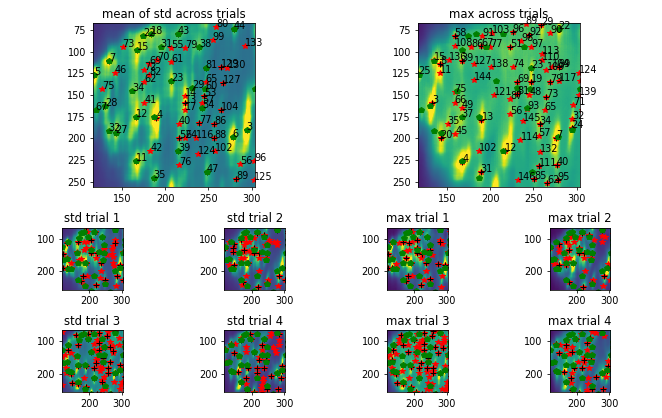

In [110]:
%matplotlib notebook
quantile = 0.99
SHOW_MAX = True
CONFIRMED = True

fig = plt.figure(figsize=(9.5, 6))  # contstained_layout=True)
layout = """
    AABB
    AABB
    CDEF
    GHIJ
    """
axs_names = "ABCDEFGHIJ"
ax_dict = fig.subplot_mosaic(layout)  # , sharex=True, sharey=True)

for i_ax, ax_name in enumerate(axs_names):
    if i_ax:
        # ax_dict[ax_name].set_xticklabels([])
        # ax_dict[ax_name].set_yticklabels([])
        ax_dict[axs_names[0]].get_shared_x_axes().join(ax_dict[axs_names[0]], ax_dict[ax_name])
        ax_dict[axs_names[0]].get_shared_y_axes().join(ax_dict[axs_names[0]], ax_dict[ax_name])
   

for i_ax, ax_name in enumerate(axs_names):
    ax = ax_dict[axs_names[i_ax]]
    if i_ax == 0:
        im = std_all
        title = "mean of std across trials"
    elif i_ax == 1:
        im = max_all
        title = "max across trials"
    else:
        i_row = (i_ax - 2) // 4
        i_col = (i_ax - 2) % 4
        if i_col < 2:  # target all the left small subplots
            i_trial = i_row * 2 + i_col
            im = stds[i_trial]
            title = "std trial {}".format(i_trial + 1)
        else:
            i_trial = i_row * 2 + i_col - 2
            im = maxs[i_trial]
            title = "max trial {}".format(i_trial + 1)
    ax.imshow(im, clim=[0, np.quantile(im, quantile)])
    ax.set_title(title)
    
    if SHOW_MAX:
        if i_ax == 0:
            coordinates5 = local_peak_std
        elif i_ax == 1:
            coordinates5 = local_peak_max
        else:
            coordinates5 = peak_local_max(im, min_distance=5, threshold_abs=0.001)
        coordinates10 = peak_local_max(im, min_distance=10, threshold_abs=0.001)
        _ = [ax.plot(pixel[1], pixel[0], 'r*') for pixel in coordinates5]
        _ = [ax.plot(pixel[1], pixel[0], 'k+') for pixel in coordinates10]
        if i_ax <= 1:
            for i in range(len(coordinates5)):
                ax.annotate(str(i), np.flip(coordinates5[i]))
    if CONFIRMED:
        _ = [ax.plot(pixel[1], pixel[0], 'gp') for pixel in confirmed_rois]
        
      
fig.tight_layout()

# enter your results into the cell below <br>
you can regularly run this cell and then create the plot again. Then you'll see the ones we already labelled in green.

In [119]:
# numbers of peaks in standard deviation image as shown on the left of the plot below

std_confirmed_rois = []
#std_confirmed_rois = [5,7,28,67,32,27,12,34,15,22,18,31,43,38,23,81,2,9,24,50,33,16,25,26,44,48,84,29,54,60,0,106,37,94,19,66,49,117,108,
#                     51,21,63,68,3,83,11,35,10,20,45,47,6,39,85,78,92,13] # 0618 - FLY 5
#std_confirmed_rois = [3,11,13,26,17,15,20,41,83,4,5,10,38,23,192,34,21,8,39,47,196,50,59,102,51,16,62,121,212,165,234,223
#                     ,53,54,76,9,22,24,32,55,18,6,14,12,28,19,29,46,37,44,36,42] # - 0603 FLY2
#std_confirmed_rois = [12,8,11,1,21,2,3,16,9,7,6,10,4,23,41,37,47,51,40,48,50,62,63,38,55,35,25,28,19,13,27,5,34,17,33,36,20,0,44,29,
#58,61,44,22] #0602/fly2
#std_confirmed_rois = [0,1,10,5,16,17,11,36,9,23,4,35,40,47,55,63,3,7,50,61,53,22,29,8,13,12,28,60] #0527 - fly4
#std_confirmed_rois = [20,4,12,131,16,28,18,0,34,41,2,40,52,60,67,63,62,61,48,47,46,1,5,15,24,] #0526 fly2
#std_confirmed_rois = [1,14,12,2,27,32,21,41,28,25,15,35,9,7,6,4,5,18,46,23,8,20,0,46,49,18,17,24,22,10,19,67,26,36,53,42
#                     ,40,13] # 0519 FLY 1
#std_confirmed_rois = [0,4,7,16,8,10,14,17,27,3,18,29,35,12,13,1,6,15,23,55,2,34,40,20,51,28,20,64,32,41,54,9,25,30,45,
#                     44,60,24,33,35] # - FLY 1 0521
#std_confirmed_rois = [0, 1, 10, 12, 15, 3, 11, 14, 7, 6, 17, 8, 46, 90, 39, 51, 33, 85, 75, 92, 117, 118, 116, 4, 28, 18,
#                     91, 49, 26, 106, 37, 31, 21, 38, 44, 86, 35, 58, 36, 57, 2, 5, 22, 94, 99, 114, 105, 87, 88, 93, 96,
#                     19, 61] # - FLY 3 0512
# numbers of peaks in standard deviation image as shown on the right of the plot below
max_confirmed_rois = []
#max_confirmed_rois = [10,42,0,6,27,33,28,53] # 0618 - FLY 5
#max_confirmed_rois = [1,24,34,57,52,81,89,92,61,82,50,2,27,88,66,16,42,95,25,58,69,99,67,44,106,114,77,86,96,97,75,118,105,23] # - 0603 FLY2
#max_confirmed_rois = [64,49,45,42,68,74,27,36,63,101,98] #0602/fly2
#max_confirmed_rois = [42,4,0,19,35,33,49,24,8,32,7,54,46,48,53,38,83,73,21,27,55,78,63,51,30,12,25,44] #0527 - fly4
#max_confirmed_rois = [15,12,18,17,27,25,24,19,22,2,11,20,34,70,64,58,52,69,80,59,86,36,85,50,30,79] #0526 fly2
#max_confirmed_rois = [28,32,9,62,28,43] # 0519 FLY 1
#max_confirmed_rois = [39,46,84,52,47] # - FLY 1 0521
#max_confirmed_rois = [19, 36, 9, 3, 122, 26, 27, 14, 23, 49, 50] #- FLY 3 0512

# numbers of peaks in local correlation image as shown on the bottom of the notebook
corr_confirmed_rois = []
#corr_confirmed_rois = [42,21,32,67,1,8,80,59,19,54,81,76,67,80,29,46] # 0618 - FLY 5
#corr_confirmed_rois = [55,47,206,9,54,35,51,76,34] # - 0603 FLY2
#corr_confirmed_rois = [51,60,69,64,84,75,19,105,58,63,84,74,54,31,77,115,112,99,43,103,95,130,66,102,98] #0602/fly2
#corr_confirmed_rois = [26,31,35,40,43,15,57,96,104,106,25,58,84,101,81,147,393,120,103,339,100] #0527 - fly4
#corr_confirmed_rois = [66,458,71,35,88,83,73,13,19,57,60,87,106,64] #0526 fly2
#corr_confirmed_rois = [65,23,55,38,104,102,146,149,107,144,152,165,160,25,147,118,154,148,151,71,53,81,35,61,108,172,173,175,40,73] # 0519 FLY 1
#corr_confirmed_rois = [1,17,30,44,61,63,70,79,95,96,80,91,33,34,68,27,41,93,99,100] # - FLY 1 0521
#corr_confirmed_rois = [21, 22,28,29,17,49,51,80,41,77,81,66,34,53,42,78,96,101,83,58] # - FLY 3 0512


# y and x coordinates of additional rois as [y, x], i.e. a list of lists: [[y1, x1], [y2, x2]]
additional_rois = []
#additional_rois = [[175,187]] # 0618 - FLY 5
#additional_rois = [[135,75],[89,138]] # - 0603 FLY2
#additional_rois = [[103,156],[93,146],[89,165]] #0602/fly2
#additional_rois = [[195,94]] #0527 - fly4
#additional_rois = [[130,113],[117,147]] #0526 fly2
#additional_rois = [[119, 129]] # 0519 FLY 1
#additional_rois = [[252, 119],[185,444],[123,268]] # - FLY 1 0521
#additional_rois = [[194, 191], [62, 356],[187, 149]] # - FLY 3 0512

confirmed_rois = np.vstack((local_peak_std[std_confirmed_rois, :], 
                            local_peak_max[max_confirmed_rois, :], 
                            local_peak_corr[corr_confirmed_rois, :], 
                            additional_rois))
print("Number of confirmed ROIs: {}".format(len(confirmed_rois)))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 3 has size 0

# potential last step: verify with local correlation image <br>
(same procedure as before: add number to list, re-run the cell, plot again.)

<IPython.core.display.Javascript object>


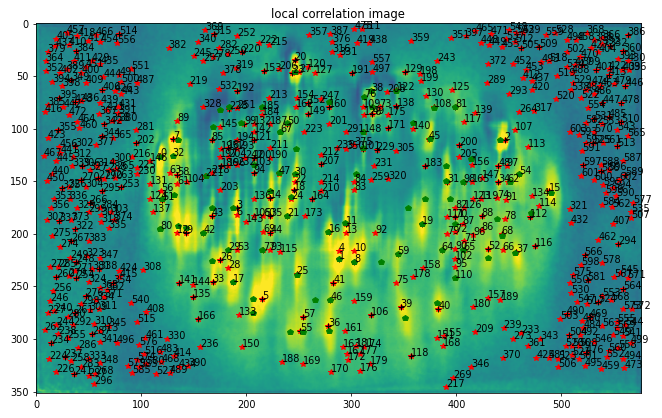

In [116]:
%matplotlib notebook
quantile = 0.99
SHOW_MAX = True
CONFIRMED = True

fig, ax = plt.subplots(1,1,figsize=(9.5, 6))
ax.imshow(local_corr_all, clim=[0, np.quantile(local_corr_all, quantile)])
ax.set_title("local correlation image")
coordinates10 = peak_local_max(local_corr_all, min_distance=10, threshold_abs=0.001)
_ = [ax.plot(pixel[1], pixel[0], 'r*') for pixel in local_peak_corr]
_ = [ax.plot(pixel[1], pixel[0], 'k+') for pixel in coordinates10]
for i in range(len(local_peak_corr)):
                ax.annotate(str(i), np.flip(local_peak_corr[i]))
_ = [ax.plot(pixel[1], pixel[0], 'gp') for pixel in confirmed_rois]
fig.tight_layout()

# Finalise the ROI detection and save results to file

In [117]:
with open(out_file, "w") as f:
    for i_c, coord in enumerate(confirmed_rois):
        string = "{:3}: {:3}, {:3}\n".format(i_c, coord[0], coord[1])
        f.write(string)
        print(string[:-2])

  0: 127, 11
  1: 111, 13
  2: 163, 13
  3: 167, 12
  4: 192, 13
  5: 194, 14
  6: 175, 16
  7: 145, 16
  8:  98, 16
  9:  82, 17
 10:  79, 18
 11:  94, 19
 12:  79, 21
 13:  94, 23
 14: 134, 20
 15: 119, 24
 16:  64, 31
 17:  79, 32
 18:  64, 34
 19:  94, 35
 20:  80, 37
 21: 110, 37
 22: 103, 31
 23: 118, 31
 24:  74, 27
 25: 143, 30
 26: 167, 37
 27: 142, 23
 28: 165, 24
 29: 143, 24
 30:  46, 24
 31: 161, 49
 32: 223, 43
 33: 218, 45
 34: 242, 39
 35: 215, 40
 36: 191, 39
 37: 186, 43
 38: 202, 44
 39: 227, 32
 40: 280, 35
 41: 266, 38
 42: 215, 38
 43: 190, 29
 44: 151, 40
 45: 226, 16
 46: 246, 18
 47: 262, 20
 48: 275, 20
 49: 292, 27
 50: 239, 24
 51: 198, 27
 52: 215, 21
 53: 293, 24
 54: 293, 25
 55: 263, 26
 56: 159, 22
 57: 135, 39
 58: 129, 41
 59: 111, 44
 60: 180, 47
 61: 150, 39
 62: 167, 39
 63: 175, 35
 64: 151, 45
 65: 199, 15
 66: 183, 23
 67: 126, 13
 68: 103, 23
 69: 224, 28
 70: 227, 30
 71: 195, 11
 72: 219, 34
 73: 191, 36
 74: 143, 46
 75:  79, 39
 76:  70, 31